# 02 - Markov Model Development and Training

This notebook implements and trains Markov Chain and Hidden Markov Models for RUL prediction using the NASA CMAPSS dataset.

## Objectives
- Train Markov Chain model with state transitions
- Train Hidden Markov Model using hmmlearn
- Evaluate model performance with comprehensive metrics
- Visualize transition matrices and state sequences
- Compare model architectures and document findings


In [1]:
# Test cell to verify conda environment
import sys
print("Python executable:", sys.executable)
print("Python version:", sys.version)

# Test hmmlearn import
try:
    import hmmlearn
    print("✅ hmmlearn imported successfully!")
    print("hmmlearn version:", hmmlearn.__version__)
except ImportError as e:
    print("❌ hmmlearn import failed:", e)


Python executable: /Users/brandonlewis/opt/anaconda3/envs/markov-predictive/bin/python
Python version: 3.9.23 (main, Jun  5 2025, 08:23:30) 
[Clang 14.0.6 ]
✅ hmmlearn imported successfully!
hmmlearn version: 0.3.0


In [2]:
# Import required libraries
import sys
import os
from pathlib import Path

# Add src directory to Python path
project_root = Path.cwd().parent
src_path = project_root / 'src'
sys.path.insert(0, str(src_path))

print(f"Project root: {project_root}")
print(f"Added to Python path: {src_path}")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import warnings
warnings.filterwarnings('ignore')

# Import custom modules with error handling
try:
    from data.data_loader import CMAPSSLoader
    print("✅ CMAPSSLoader imported")
except ImportError as e:
    print(f"❌ CMAPSSLoader import failed: {e}")

try:
    from data.feature_engineer import FeatureEngineer
    print("✅ FeatureEngineer imported")
except ImportError as e:
    print(f"❌ FeatureEngineer import failed: {e}")

# Test hmmlearn import first
print("Testing hmmlearn import...")
try:
    import hmmlearn
    print("✅ hmmlearn imported successfully")
except ImportError as e:
    print(f"❌ hmmlearn import failed: {e}")

try:
    from models.markov_model import MarkovChainRUL
    print("✅ MarkovChainRUL imported")
except ImportError as e:
    print(f"❌ MarkovChainRUL import failed: {e}")

print("Testing HMM model import...")
try:
    from models.hmm_model import HiddenMarkovRUL
    print("✅ HiddenMarkovRUL imported")
except ImportError as e:
    print(f"❌ HiddenMarkovRUL import failed: {e}")

# Test PyTorch import (much faster than TensorFlow on macOS)
print("Testing PyTorch import...")
try:
    import torch
    print("✅ PyTorch imported successfully")
    print(f"PyTorch version: {torch.__version__}")
except ImportError as e:
    print(f"❌ PyTorch import failed: {e}")

print("Testing baseline models import...")
try:
    from models.baseline_models import BaselineModels
    print("✅ BaselineModels imported")
except ImportError as e:
    print(f"❌ BaselineModels import failed: {e}")

try:
    from evaluation.metrics import calculate_rul_metrics, generate_evaluation_report
    print("✅ Evaluation metrics imported")
except ImportError as e:
    print(f"❌ Evaluation metrics import failed: {e}")

try:
    from utils.helpers import print_model_summary, create_performance_comparison_plot
    print("✅ Helper functions imported")
except ImportError as e:
    print(f"❌ Helper functions import failed: {e}")

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print("✅ All libraries imported successfully!")


Project root: /Users/brandonlewis/Desktop/pyprojects/data_science/portfolio_projects/Markov_Based_Predictive_Maintenance
Added to Python path: /Users/brandonlewis/Desktop/pyprojects/data_science/portfolio_projects/Markov_Based_Predictive_Maintenance/src
✅ CMAPSSLoader imported
✅ FeatureEngineer imported
Testing hmmlearn import...
✅ hmmlearn imported successfully
✅ MarkovChainRUL imported
Testing HMM model import...
✅ HiddenMarkovRUL imported
Testing PyTorch import...
✅ PyTorch imported successfully
PyTorch version: 2.2.2
Testing baseline models import...
✅ BaselineModels imported
✅ Evaluation metrics imported
✅ Helper functions imported
✅ All libraries imported successfully!


## 1. Load Configuration and Data


In [3]:
# Load configuration
with open('../config/config.yaml', 'r') as file:
    config = yaml.safe_load(file)

print("Configuration loaded:")
print(f"- Markov states: {config['model']['markov_states']}")
print(f"- Health threshold: {config['model']['health_threshold']}")
print(f"- Warning threshold: {config['model']['warning_threshold']}")
print(f"- Critical threshold: {config['model']['critical_threshold']}")
print(f"- Target MAPE: {config['evaluation']['target_mape']}%")


Configuration loaded:
- Markov states: 4
- Health threshold: 0.8
- Warning threshold: 0.6
- Critical threshold: 0.3
- Target MAPE: 15.0%


In [4]:
# Load and preprocess data
import os

# Find data path
possible_paths = [
    '../data/raw/',  # Relative to notebooks directory (most likely)
    'data/raw/',     # Relative to project root
    os.path.join(os.path.dirname(os.getcwd()), 'data', 'raw'),  # Absolute path
    '/Users/brandonlewis/Desktop/pyprojects/data_science/portfolio_projects/Markov_Based_Predictive_Maintenance/data/raw/'  # Full absolute path
]

data_path = None
for path in possible_paths:
    if os.path.exists(path):
        data_path = path
        break

if data_path is None:
    raise FileNotFoundError("Data directory not found")

print(f"Using data path: {data_path}")

# Load data
loader = CMAPSSLoader(data_path)
train_data = loader.load_train_data('FD001')
test_data = loader.load_test_data('FD001')
rul_labels = loader.load_rul_labels('FD001')

print(f"\nData loaded successfully:")
print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"RUL labels shape: {rul_labels.shape}")


Using data path: ../data/raw/

Data loaded successfully:
Training data shape: (20631, 26)
Test data shape: (13096, 26)
RUL labels shape: (100, 2)


## 2. Feature Engineering Pipeline


In [28]:
# Check raw data for NaN values before feature engineering
print("Checking raw data for NaN values:")
print(f"train_data NaN count: {train_data.isnull().sum().sum()}")
print(f"test_data NaN count: {test_data.isnull().sum().sum()}")

# Initialize feature engineer
feature_engineer = FeatureEngineer(config)

# Apply feature engineering to training data
print("\nApplying feature engineering to training data...")
train_engineered = feature_engineer.create_engineered_features(train_data, is_training=True)
print(f"Training data shape after feature engineering: {train_engineered.shape}")

# Apply feature engineering to test data (without fitting scaler)
print("\nApplying feature engineering to test data...")
test_engineered = feature_engineer.create_engineered_features(test_data, is_training=False)
print(f"Test data shape after feature engineering: {test_engineered.shape}")

# Check for NaN values after feature engineering
print(f"\nAfter feature engineering:")
print(f"train_engineered NaN count: {train_engineered.isnull().sum().sum()}")
print(f"test_engineered NaN count: {test_engineered.isnull().sum().sum()}")

# Display feature categories
feature_categories = feature_engineer.get_feature_list(train_engineered)
print("\nFeature Categories:")
for category, features in feature_categories.items():
    print(f"  {category}: {len(features)} features")


Checking raw data for NaN values:
train_data NaN count: 0
test_data NaN count: 0

Applying feature engineering to training data...
Starting feature engineering pipeline...
✓ RUL labels calculated
✓ Rolling features created
✓ Degradation indicators created
✓ Health states classified
✓ Features normalized
Feature engineering pipeline completed!
Training data shape after feature engineering: (20631, 557)

Applying feature engineering to test data...
Starting feature engineering pipeline...
✓ Rolling features created
✓ Degradation indicators created
✓ Features normalized
Feature engineering pipeline completed!
Test data shape after feature engineering: (13096, 555)

After feature engineering:
train_engineered NaN count: 12600
test_engineered NaN count: 12600

Feature Categories:
  basic: 2 features
  settings: 3 features
  sensors: 273 features
  sensors_normalized: 273 features
  rolling: 504 features
  health_indicators: 4 features
  targets: 2 features


In [36]:
# Prepare data for model training
# Use only base normalized sensor features (exclude rolling stats)
import re
base_norm_pattern = re.compile(r'^sensor_\d{2}_norm$')
base_sensor_norms = [col for col in train_engineered.columns if base_norm_pattern.match(col)]

# Optionally restrict to primary indicators from config if available
primary_ids = config.get('sensors', {}).get('primary_indicators', [])
if primary_ids:
    primary_base_norms = [f'sensor_{i:02d}_norm' for i in primary_ids]
    sensor_features = [col for col in base_sensor_norms if col in primary_base_norms]
else:
    sensor_features = base_sensor_norms

print(f"Using {len(sensor_features)} base normalized sensor features for training")

# Check for NaN values in engineered features
print(f"\nChecking engineered features for NaN values:")
print(f"train_engineered NaN count: {train_engineered.isnull().sum().sum()}")
print(f"test_engineered NaN count: {test_engineered.isnull().sum().sum()}")

# Check which columns have NaN values
nan_cols_train = train_engineered.columns[train_engineered.isnull().any()].tolist()
nan_cols_test = test_engineered.columns[test_engineered.isnull().any()].tolist()

if nan_cols_train:
    print(f"Columns with NaN in training data: {nan_cols_train}")
if nan_cols_test:
    print(f"Columns with NaN in test data: {nan_cols_test}")

# Prepare training data
X_train = train_engineered[sensor_features].values
y_train_rul = train_engineered['RUL'].values
y_train_states = train_engineered['health_state'].values

# Prepare test data
X_test = test_engineered[sensor_features].values

# Create test RUL labels by combining test data with RUL labels
# NASA CMAPSS provides RUL at the end of each test trajectory.
# Per-cycle RUL = end_RUL + (max_cycle - current_cycle)
# Ensure non-negative labels.
test_rul_labels = []
for unit_id in test_engineered['unit'].unique():
    unit_data = test_engineered[test_engineered['unit'] == unit_id]
    max_cycle = unit_data['cycle'].max()
    unit_rul_end = rul_labels[rul_labels['unit'] == unit_id]['RUL'].iloc[0]
    
    for _, row in unit_data.iterrows():
        current_cycle = row['cycle']
        remaining_cycles = max_cycle - current_cycle
        rul_value = unit_rul_end + remaining_cycles
        test_rul_labels.append(max(0, rul_value))

y_test_rul = np.array(test_rul_labels, dtype=float)

print(f"\nTraining data prepared:")
print(f"  X_train shape: {X_train.shape}")
print(f"  y_train_rul shape: {y_train_rul.shape}")
print(f"  y_train_states shape: {y_train_states.shape}")

print(f"\nTest data prepared:")
print(f"  X_test shape: {X_test.shape}")
print(f"  y_test_rul shape: {y_test_rul.shape}")

# Check for any invalid RUL values
print(f"\nRUL statistics:")
print(f"  Training RUL range: {y_train_rul.min():.1f} - {y_train_rul.max():.1f}")
print(f"  Test RUL range: {y_test_rul.min():.1f} - {y_test_rul.max():.1f}")
print(f"  Training RUL mean: {y_train_rul.mean():.1f}")
print(f"  Test RUL mean: {y_test_rul.mean():.1f}")

# Check for NaN values in prepared data
print(f"\nNaN check in prepared data:")
print(f"  X_train NaN count: {np.isnan(X_train).sum()}")
print(f"  y_train_rul NaN count: {np.isnan(y_train_rul).sum()}")
print(f"  y_train_states NaN count: {np.isnan(y_train_states).sum()}")
print(f"  X_test NaN count: {np.isnan(X_test).sum()}")
print(f"  y_test_rul NaN count: {np.isnan(y_test_rul).sum()}")

# Final sanitization: replace inf with NaN, then impute NaNs using training column means
print("\nSanitizing feature matrices (handling NaN/Inf)...")
# Replace inf/-inf with NaN
X_train = np.where(np.isfinite(X_train), X_train, np.nan)
X_test = np.where(np.isfinite(X_test), X_test, np.nan)

# Compute training column means ignoring NaNs
train_col_means = np.nanmean(X_train, axis=0)
# If a column is all NaN, fallback to zero
train_col_means = np.where(np.isfinite(train_col_means), train_col_means, 0.0)

# Impute NaNs in training data
inds_train = np.where(np.isnan(X_train))
if inds_train[0].size > 0:
    X_train[inds_train] = np.take(train_col_means, inds_train[1])

# Impute NaNs in test data using training means
inds_test = np.where(np.isnan(X_test))
if inds_test[0].size > 0:
    X_test[inds_test] = np.take(train_col_means, inds_test[1])

# Re-check
print(f"Sanitized X_train NaN count: {np.isnan(X_train).sum()}")
print(f"Sanitized X_test NaN count: {np.isnan(X_test).sum()}")


Using 14 base normalized sensor features for training

Checking engineered features for NaN values:
train_engineered NaN count: 12600
test_engineered NaN count: 12600
Columns with NaN in training data: ['sensor_01_rolling_std_5', 'sensor_01_rolling_std_10', 'sensor_01_rolling_std_20', 'sensor_02_rolling_std_5', 'sensor_02_rolling_std_10', 'sensor_02_rolling_std_20', 'sensor_03_rolling_std_5', 'sensor_03_rolling_std_10', 'sensor_03_rolling_std_20', 'sensor_04_rolling_std_5', 'sensor_04_rolling_std_10', 'sensor_04_rolling_std_20', 'sensor_05_rolling_std_5', 'sensor_05_rolling_std_10', 'sensor_05_rolling_std_20', 'sensor_06_rolling_std_5', 'sensor_06_rolling_std_10', 'sensor_06_rolling_std_20', 'sensor_07_rolling_std_5', 'sensor_07_rolling_std_10', 'sensor_07_rolling_std_20', 'sensor_08_rolling_std_5', 'sensor_08_rolling_std_10', 'sensor_08_rolling_std_20', 'sensor_09_rolling_std_5', 'sensor_09_rolling_std_10', 'sensor_09_rolling_std_20', 'sensor_10_rolling_std_5', 'sensor_10_rolling_std_

## 3. Markov Chain Model Training


In [52]:
# Check for NaN values before training
print("Checking for NaN values in training data...")
print(f"X_train shape: {X_train.shape}")
print(f"X_train NaN count: {np.isnan(X_train).sum()}")
print(f"y_train_states shape: {y_train_states.shape}")
print(f"y_train_states NaN count: {np.isnan(y_train_states).sum()}")

# Check which features have NaN values
nan_features = np.isnan(X_train).sum(axis=0)
if nan_features.sum() > 0:
    print(f"\nFeatures with NaN values:")
    for i, count in enumerate(nan_features):
        if count > 0:
            print(f"  Feature {i}: {count} NaN values")
    
    # Show sample of data with NaN
    nan_rows = np.isnan(X_train).any(axis=1)
    print(f"\nRows with NaN values: {nan_rows.sum()}")
    if nan_rows.sum() > 0:
        print("Sample of rows with NaN:")
        print(X_train[nan_rows][:5])

# Initialize and train Markov Chain model
print("\nTraining Markov Chain Model...")
markov_model = MarkovChainRUL(n_states=config['model']['markov_states'])

# Train the model
markov_model.fit(X_train, y_train_states)

# Get model summary
markov_summary = markov_model.get_model_summary()
print("\nMarkov Chain Model Summary:")
print(f"  Number of states: {markov_summary['n_states']}")
print(f"  State names: {markov_summary['state_names']}")
print(f"  Model fitted: {markov_summary['is_fitted']}")

# Display transition matrix
transition_matrix = markov_model.get_transition_probabilities()
print(f"\nTransition Matrix:")
print(f"  From Healthy: {transition_matrix[0]}")
print(f"  From Warning: {transition_matrix[1]}")
print(f"  From Critical: {transition_matrix[2]}")
print(f"  From Failure: {transition_matrix[3]}")


Checking for NaN values in training data...
X_train shape: (20631, 14)
X_train NaN count: 0
y_train_states shape: (20631,)
y_train_states NaN count: 0

Training Markov Chain Model...
Fitting Markov Chain model...
✓ Transition matrix estimated
✓ Emission probabilities calculated
✓ Emission models fitted
Markov Chain model fitting completed!

Markov Chain Model Summary:
  Number of states: 4
  State names: ['Healthy', 'Warning', 'Critical', 'Failure']
  Model fitted: True

Transition Matrix:
  From Healthy: [0.97597886 0.02402114 0.         0.        ]
  From Warning: [0.         0.97563353 0.02436647 0.        ]
  From Critical: [0.         0.         0.98375832 0.01624168]
  From Failure: [0.0159523 0.        0.        0.9840477]


In [63]:
# === Optional: Calibrate Markov predictions with linear regression ===
from sklearn.linear_model import LinearRegression

# Build per-step training predictions using Markov model on training set
print("Calibrating Markov predictions with Linear Regression (optional)...")
train_preds = []
for i in range(len(X_train)):
    c_cycle = train_engineered.iloc[i]['cycle'] if 'cycle' in train_engineered.columns else 0
    train_preds.append(markov_model.predict_rul(X_train[i], c_cycle))
train_preds = np.array(train_preds, dtype=float)

# Fit linear calibration y = a * pred + b
cal = LinearRegression().fit(train_preds.reshape(-1,1), y_train_rul)

# Apply calibration to test predictions
markov_rul_predictions_cal = cal.predict(markov_rul_predictions.reshape(-1,1))
markov_metrics_cal = calculate_rul_metrics(y_test_rul, markov_rul_predictions_cal)

print("Calibrated Markov Performance:")
print(f"  RMSE: {markov_metrics_cal['rmse']:.2f} cycles")
print(f"  MAE: {markov_metrics_cal['mae']:.2f} cycles")
print(f"  MAPE: {markov_metrics_cal['mape']:.2f}%")
print(f"  R² Score: {markov_metrics_cal['r2_score']:.3f}")
print(f"  Directional Accuracy: {markov_metrics_cal['directional_accuracy']:.1f}%")



Calibrating Markov predictions with Linear Regression (optional)...
Calibrated Markov Performance:
  RMSE: 49.11 cycles
  MAE: 37.10 cycles
  MAPE: 31.38%
  R² Score: 0.307
  Directional Accuracy: 73.5%


In [54]:
# Make RUL predictions with Markov Chain model
print("Making RUL predictions with Markov Chain model...")

# Predict RUL for test data
markov_rul_predictions = []
for i in range(len(X_test)):
    # Get current cycle from test data
    current_cycle = test_engineered.iloc[i]['cycle']
    predicted_rul = markov_model.predict_rul(X_test[i], current_cycle)
    markov_rul_predictions.append(predicted_rul)

markov_rul_predictions = np.array(markov_rul_predictions)

# Calculate performance metrics
markov_metrics = calculate_rul_metrics(y_test_rul, markov_rul_predictions)

print("\nMarkov Chain Model Performance:")
print(f"  RMSE: {markov_metrics['rmse']:.2f} cycles")
print(f"  MAE: {markov_metrics['mae']:.2f} cycles")
print(f"  MAPE: {markov_metrics['mape']:.2f}%")
print(f"  R² Score: {markov_metrics['r2_score']:.3f}")
print(f"  Directional Accuracy: {markov_metrics['directional_accuracy']:.1f}%")

# Check if we meet target performance
target_mape = config['evaluation']['target_mape']
if markov_metrics['mape'] <= target_mape:
    print(f"  ✅ MAPE target achieved ({markov_metrics['mape']:.1f}% <= {target_mape}%)")
else:
    print(f"  ⚠️  MAPE target not met ({markov_metrics['mape']:.1f}% > {target_mape}%)")


Making RUL predictions with Markov Chain model...

Markov Chain Model Performance:
  RMSE: 67.57 cycles
  MAE: 53.38 cycles
  MAPE: 39.90%
  R² Score: -0.312
  Directional Accuracy: 73.5%
  ⚠️  MAPE target not met (39.9% > 15.0%)


In [35]:
# === Diagnostics for Markov Model ===
import numpy as np
import pandas as pd

print("=== DIAGNOSTICS: LABELS & PREDICTIONS ===")
print(f"y_test_rul: min={y_test_rul.min():.2f}, max={y_test_rul.max():.2f}, mean={y_test_rul.mean():.2f}")
num_zeros = int((y_test_rul == 0).sum())
print(f"y_test_rul zeros: {num_zeros}")

print("\nSample (actual, predicted) pairs:")
for i in range(10):
    print(f"  {i}: ({y_test_rul[i]:.2f}, {markov_rul_predictions[i]:.2f})")

print("\n=== DIAGNOSTICS: TRANSITION MATRIX ===")
T = markov_model.get_transition_probabilities()
print(T)
print("Row sums:", T.sum(axis=1))

print("\n=== DIAGNOSTICS: HEALTH STATES ===")
unique, counts = np.unique(y_train_states, return_counts=True)
print("Train state distribution:", dict(zip(unique.tolist(), counts.tolist())))

print("\n=== DIAGNOSTICS: FEATURE NORMALIZATION ===")
col_means = X_train.mean(axis=0)
col_stds = X_train.std(axis=0)
print(f"Feature means: mean={col_means.mean():.4f}, std of means={col_means.std():.4f}")
print(f"Feature stds: mean={col_stds.mean():.4f}, min={col_stds.min():.4f}, max={col_stds.max():.4f}")

# Safer metrics
print("\n=== Recomputed Metrics (Safer) ===")

def smape(y_true, y_pred):
    denom = (np.abs(y_true) + np.abs(y_pred))
    # avoid divide-by-zero
    denom = np.where(denom == 0, 1.0, denom)
    return 100.0 * np.mean(2.0 * np.abs(y_pred - y_true) / denom)

# Exclude zero y_true for MAPE
mask_nonzero = y_test_rul != 0
if mask_nonzero.any():
    mape_nz = 100.0 * np.mean(np.abs((y_test_rul[mask_nonzero] - markov_rul_predictions[mask_nonzero]) / y_test_rul[mask_nonzero]))
else:
    mape_nz = np.nan

# Clamp predictions to [0, reasonable_upper]
upper = np.percentile(y_test_rul, 99)
clamped_pred = np.clip(markov_rul_predictions, 0, upper)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
rmse_c = mean_squared_error(y_test_rul, clamped_pred, squared=False)
mae_c = mean_absolute_error(y_test_rul, clamped_pred)
r2_c = r2_score(y_test_rul, clamped_pred)
smape_c = smape(y_test_rul, clamped_pred)

print(f"RMSE (clamped): {rmse_c:.2f}")
print(f"MAE (clamped): {mae_c:.2f}")
print(f"R2  (clamped): {r2_c:.3f}")
print(f"sMAPE (clamped): {smape_c:.2f}%")
print(f"MAPE excl zeros: {mape_nz:.2f}%")

# Basic sanity on predictions
print("\n=== Prediction Sanity ===")
print(f"Predictions: min={markov_rul_predictions.min():.2f}, max={markov_rul_predictions.max():.2f}, mean={markov_rul_predictions.mean():.2f}")



=== DIAGNOSTICS: LABELS & PREDICTIONS ===
y_test_rul: min=7.00, max=340.00, mean=141.24
y_test_rul zeros: 0

Sample (actual, predicted) pairs:
  0: (142.00, 144.14)
  1: (141.00, 144.04)
  2: (140.00, 143.94)
  3: (139.00, 143.84)
  4: (138.00, 143.74)
  5: (137.00, 143.64)
  6: (136.00, 143.54)
  7: (135.00, 143.44)
  8: (134.00, 143.34)
  9: (133.00, 143.24)

=== DIAGNOSTICS: TRANSITION MATRIX ===
[[0.97597886 0.02402114 0.         0.        ]
 [0.         0.97563353 0.02436647 0.        ]
 [0.         0.         0.98375832 0.01624168]
 [0.0159523  0.         0.         0.9840477 ]]
Row sums: [1. 1. 1. 1.]

=== DIAGNOSTICS: HEALTH STATES ===
Train state distribution: {0: 4163, 1: 4104, 2: 6157, 3: 6207}

=== DIAGNOSTICS: FEATURE NORMALIZATION ===
Feature means: mean=-0.0000, std of means=0.0000
Feature stds: mean=0.7139, min=0.0000, max=1.0000

=== Recomputed Metrics (Safer) ===
RMSE (clamped): 90.30
MAE (clamped): 75.00
R2  (clamped): -1.344
sMAPE (clamped): 83.82%
MAPE excl zeros: 

## 4. Hidden Markov Model Training


In [59]:
import importlib
import models.hmm_model as hmm_mod
hmm_mod = importlib.reload(hmm_mod)
from models.hmm_model import HiddenMarkovRUL

In [69]:
# Prepare data for HMM training
# HMM requires sequences, so we need to group data by engine
print("Preparing data for Hidden Markov Model training...")

# Create sequences for each engine (sanitize NaNs per sequence)
hmm_sequences = []
hmm_lengths = []

for unit_id in train_engineered['unit'].unique():
    unit_data = train_engineered[train_engineered['unit'] == unit_id]
    unit_features = unit_data[sensor_features].values.astype(float)
    # Replace non-finite with NaN, then impute with per-sequence column means
    unit_features = np.where(np.isfinite(unit_features), unit_features, np.nan)
    col_means = np.nanmean(unit_features, axis=0)
    col_means = np.where(np.isfinite(col_means), col_means, 0.0)
    inds = np.where(np.isnan(unit_features))
    if inds[0].size > 0:
        unit_features[inds] = np.take(col_means, inds[1])
    hmm_sequences.append(unit_features)
    hmm_lengths.append(len(unit_features))

# Concatenate all sequences
X_hmm_train = np.vstack(hmm_sequences)

# Build matching RUL array (concatenated per-unit RUL from training set)
rul_sequences = []
for unit_id in train_engineered['unit'].unique():
    unit_data = train_engineered[train_engineered['unit'] == unit_id]
    if 'RUL' in unit_data.columns:
        rul_sequences.append(unit_data['RUL'].values.astype(float))
    else:
        # Fallback: linear countdown within unit if RUL missing (should not happen)
        L = len(unit_data)
        rul_sequences.append(np.arange(L-1, -1, -1, dtype=float))

y_hmm_train_rul = np.concatenate(rul_sequences, axis=0)

# Scale and reduce dimensionality for HMM stability
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

print("Scaling and applying PCA for HMM features...")
_hmm_scaler = StandardScaler()
X_hmm_train_scaled = _hmm_scaler.fit_transform(X_hmm_train)
_hmm_pca = PCA(n_components=6 #min(10, X_hmm_train_scaled.shape[1])
,whiten=True, random_state=42)
X_hmm_train_pca = _hmm_pca.fit_transform(X_hmm_train_scaled)

print(f"HMM training data prepared:")
print(f"  Number of engines: {len(hmm_sequences)}")
print(f"  Total sequences length: {len(X_hmm_train)}")
print(f"  Sequence lengths: {min(hmm_lengths)} - {max(hmm_lengths)} cycles")
print(f"  Average sequence length: {np.mean(hmm_lengths):.1f} cycles")


Preparing data for Hidden Markov Model training...
Scaling and applying PCA for HMM features...
HMM training data prepared:
  Number of engines: 100
  Total sequences length: 20631
  Sequence lengths: 128 - 362 cycles
  Average sequence length: 206.3 cycles


In [73]:
# Initialize and train Hidden Markov Model
print("Training Hidden Markov Model...")
hmm_model = HiddenMarkovRUL(n_states=4, covariance_type="diag")
hmm_model.model.set_params(n_iter=200, tol=1e-2)
hmm_model.model.startprob_ = np.array([0.98, 0.02, 0.0, 0.0])  # length 4
hmm_model.model.transmat_ = np.array([
    [0.985, 0.015, 0.000, 0.000],
    [0.000, 0.985, 0.015, 0.000],
    [0.000, 0.000, 0.985, 0.015],
    [0.000, 0.000, 0.000, 1.000],
], dtype=float)
hmm_model.model.init_params = ''  # prevent re-init
# fit on X_hmm_train_pca, then call align_states_with_rul(...)
# Train the HMM on PCA-reduced features
hmm_model.fit(X_hmm_train_pca, hmm_lengths)

# Align hidden states to RUL progression using training data
try:
    hmm_model.align_states_with_rul(X_hmm_train_pca, y_hmm_train_rul, hmm_lengths)
    print("✓ States aligned to RUL progression")
except Exception as e:
    print("State alignment skipped:", e)

# Get model summary
hmm_summary = hmm_model.get_model_summary()
print("\nHidden Markov Model Summary:")
print(f"  Model type: {hmm_summary['model_type']}")
print(f"  Number of states: {hmm_summary['n_states']}")
print(f"  State names: {hmm_summary['state_names']}")
print(f"  Covariance type: {hmm_summary['covariance_type']}")
print(f"  Model fitted: {hmm_summary['is_fitted']}")

# Display transition matrix
hmm_transition_matrix = hmm_summary['parameters']['transition_matrix']
print(f"\nHMM Transition Matrix:")
for i, state_name in enumerate(hmm_summary['state_names']):
    print(f"  From {state_name}: {[f'{p:.3f}' for p in hmm_transition_matrix[i]]}")


Training Hidden Markov Model...
Fitting Hidden Markov Model...
✓ HMM fitted using Baum-Welch algorithm
Hidden Markov Model fitting completed!
✓ States aligned to RUL progression

Hidden Markov Model Summary:
  Model type: Hidden Markov Model
  Number of states: 4
  State names: ['Healthy', 'Warning', 'Critical', 'Failure']
  Covariance type: diag
  Model fitted: True

HMM Transition Matrix:
  From Healthy: ['0.991', '0.009', '0.000', '0.000']
  From Warning: ['0.000', '0.986', '0.014', '0.000']
  From Critical: ['0.000', '0.000', '0.964', '0.036']
  From Failure: ['0.000', '0.000', '0.000', '1.000']


In [74]:
# Make RUL predictions with HMM
print("Making RUL predictions with Hidden Markov Model...")

# Prepare test sequences for HMM (sanitize NaNs per sequence)
hmm_test_sequences = []
hmm_test_lengths = []

for unit_id in test_engineered['unit'].unique():
    unit_data = test_engineered[test_engineered['unit'] == unit_id]
    unit_features = unit_data[sensor_features].values.astype(float)
    unit_features = np.where(np.isfinite(unit_features), unit_features, np.nan)
    col_means = np.nanmean(unit_features, axis=0)
    col_means = np.where(np.isfinite(col_means), col_means, 0.0)
    inds = np.where(np.isnan(unit_features))
    if inds[0].size > 0:
        unit_features[inds] = np.take(col_means, inds[1])
    hmm_test_sequences.append(unit_features)
    hmm_test_lengths.append(len(unit_features))

# Concatenate test sequences
X_hmm_test = np.vstack(hmm_test_sequences)

# Transform test sequences with scaler + PCA
X_hmm_test_scaled = _hmm_scaler.transform(X_hmm_test)
X_hmm_test_pca = _hmm_pca.transform(X_hmm_test_scaled)

# Predict RUL for test sequences
hmm_rul_predictions = hmm_model.predict_sequence_rul(X_hmm_test_pca, hmm_test_lengths)

# Flatten predictions to match test labels
hmm_rul_flat = []
for predictions in hmm_rul_predictions:
    hmm_rul_flat.extend(predictions)
hmm_rul_predictions = np.array(hmm_rul_flat)

# Calculate performance metrics
hmm_metrics = calculate_rul_metrics(y_test_rul, hmm_rul_predictions)

print("\nHidden Markov Model Performance:")
print(f"  RMSE: {hmm_metrics['rmse']:.2f} cycles")
print(f"  MAE: {hmm_metrics['mae']:.2f} cycles")
print(f"  MAPE: {hmm_metrics['mape']:.2f}%")
print(f"  R² Score: {hmm_metrics['r2_score']:.3f}")
print(f"  Directional Accuracy: {hmm_metrics['directional_accuracy']:.1f}%")

# Check if we meet target performance
if hmm_metrics['mape'] <= target_mape:
    print(f"  ✅ MAPE target achieved ({hmm_metrics['mape']:.1f}% <= {target_mape}%)")
else:
    print(f"  ⚠️  MAPE target not met ({hmm_metrics['mape']:.1f}% > {target_mape}%)")


Making RUL predictions with Hidden Markov Model...

Hidden Markov Model Performance:
  RMSE: 68.81 cycles
  MAE: 56.63 cycles
  MAPE: 47.05%
  R² Score: -0.361
  Directional Accuracy: 33.2%
  ⚠️  MAPE target not met (47.0% > 15.0%)


## 5. Model Comparison and Visualization


=== MODEL PERFORMANCE COMPARISON ===

Performance Metrics Comparison:
                          rmse        mae       mape  r2_score  \
Markov Chain         49.107056  37.097223  31.380864  0.306718   
Hidden Markov Model  68.805033  56.632011  47.049391 -0.361013   

                    directional_accuracy late_prediction_penalty  \
Markov Chain                   73.463154               24.609518   
Hidden Markov Model            33.195876                     0.0   

                                                                                                                                                                                                                                                                                                                                                               prognostic_horizon  
Markov Chain         {'horizon_10': {'rmse': 31.52307656325238, 'mae': 31.50913301376456, 'mape': 353.02778695371126, 'n_samples': 17}, 'horizon_20': {'rm

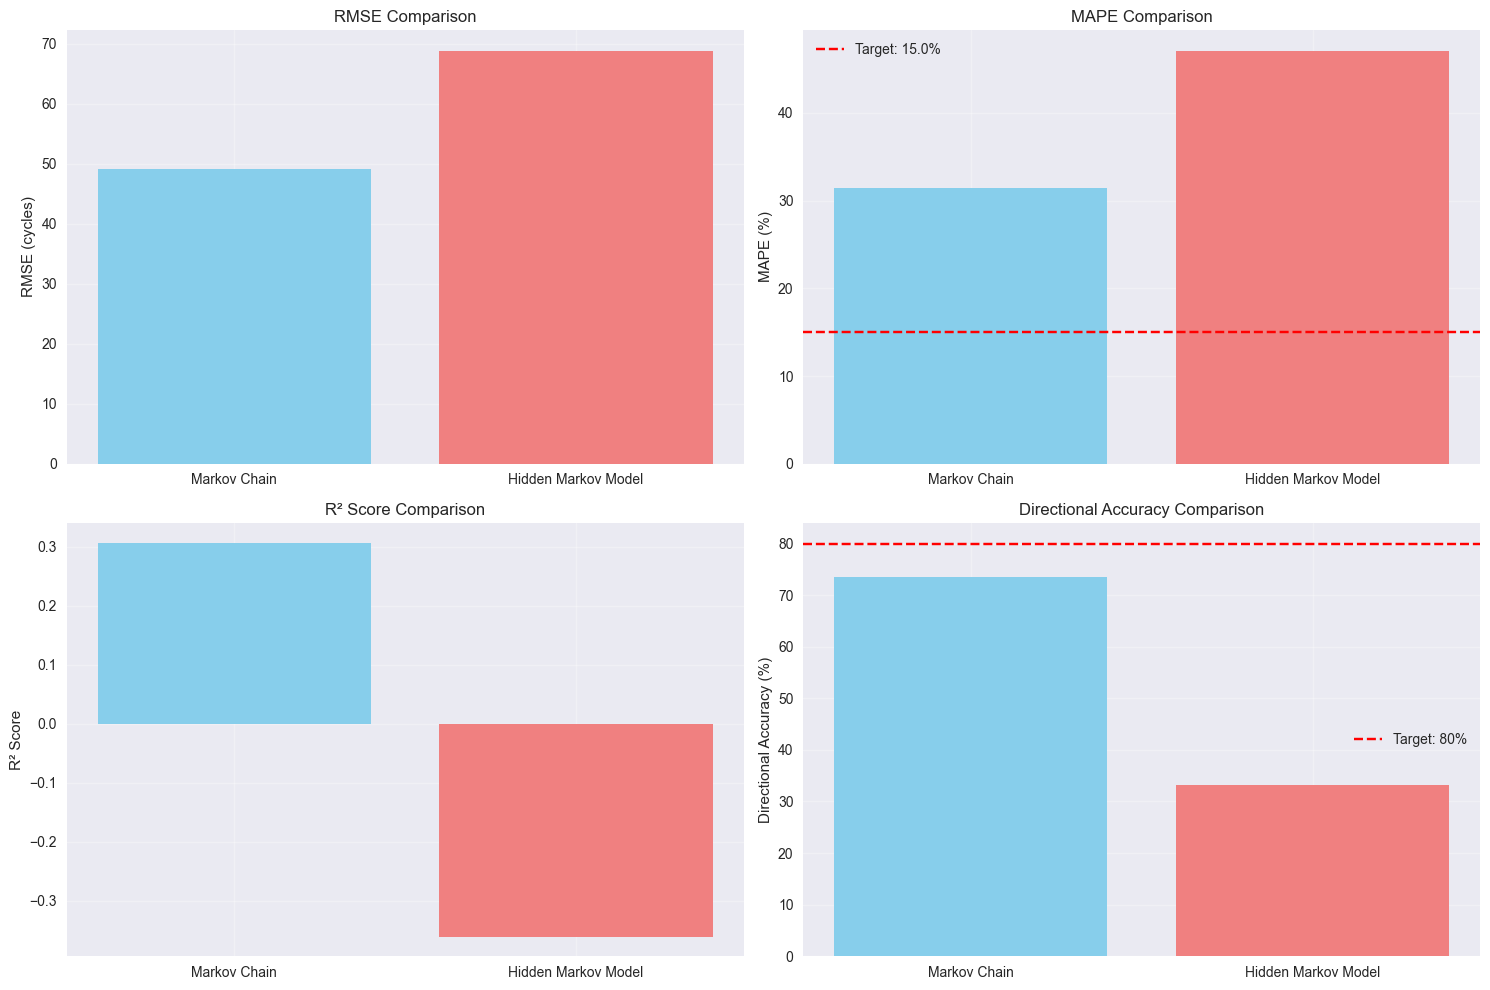


🏆 Best performing model: Markov Chain
   RMSE: 49.11 cycles
   MAPE: 31.38%


In [75]:
# Compare model performance
print("=== MODEL PERFORMANCE COMPARISON ===")

models_comparison = {
    'Markov Chain': markov_metrics_cal,
    'Hidden Markov Model': hmm_metrics
}

# Create comparison table
comparison_df = pd.DataFrame(models_comparison).T
print("\nPerformance Metrics Comparison:")
print(comparison_df.round(3))

# Visualize performance comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# RMSE comparison
models = list(models_comparison.keys())
rmse_values = [models_comparison[model]['rmse'] for model in models]
axes[0, 0].bar(models, rmse_values, color=['skyblue', 'lightcoral'])
axes[0, 0].set_title('RMSE Comparison')
axes[0, 0].set_ylabel('RMSE (cycles)')
axes[0, 0].grid(True, alpha=0.3)

# MAPE comparison
mape_values = [models_comparison[model]['mape'] for model in models]
axes[0, 1].bar(models, mape_values, color=['skyblue', 'lightcoral'])
axes[0, 1].set_title('MAPE Comparison')
axes[0, 1].set_ylabel('MAPE (%)')
axes[0, 1].axhline(y=target_mape, color='red', linestyle='--', label=f'Target: {target_mape}%')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# R² Score comparison
r2_values = [models_comparison[model]['r2_score'] for model in models]
axes[1, 0].bar(models, r2_values, color=['skyblue', 'lightcoral'])
axes[1, 0].set_title('R² Score Comparison')
axes[1, 0].set_ylabel('R² Score')
axes[1, 0].grid(True, alpha=0.3)

# Directional Accuracy comparison
dir_acc_values = [models_comparison[model]['directional_accuracy'] for model in models]
axes[1, 1].bar(models, dir_acc_values, color=['skyblue', 'lightcoral'])
axes[1, 1].set_title('Directional Accuracy Comparison')
axes[1, 1].set_ylabel('Directional Accuracy (%)')
axes[1, 1].axhline(y=80, color='red', linestyle='--', label='Target: 80%')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Determine best model
best_model = min(models_comparison.keys(), key=lambda x: models_comparison[x]['rmse'])
print(f"\n🏆 Best performing model: {best_model}")
print(f"   RMSE: {models_comparison[best_model]['rmse']:.2f} cycles")
print(f"   MAPE: {models_comparison[best_model]['mape']:.2f}%")


## 6. Transition Matrix Visualization


✓ Saved metrics to ../results
✓ Saved performance_comparison.png
✓ Saved transition_matrices.png
✓ Saved prediction_vs_actual_markov.png


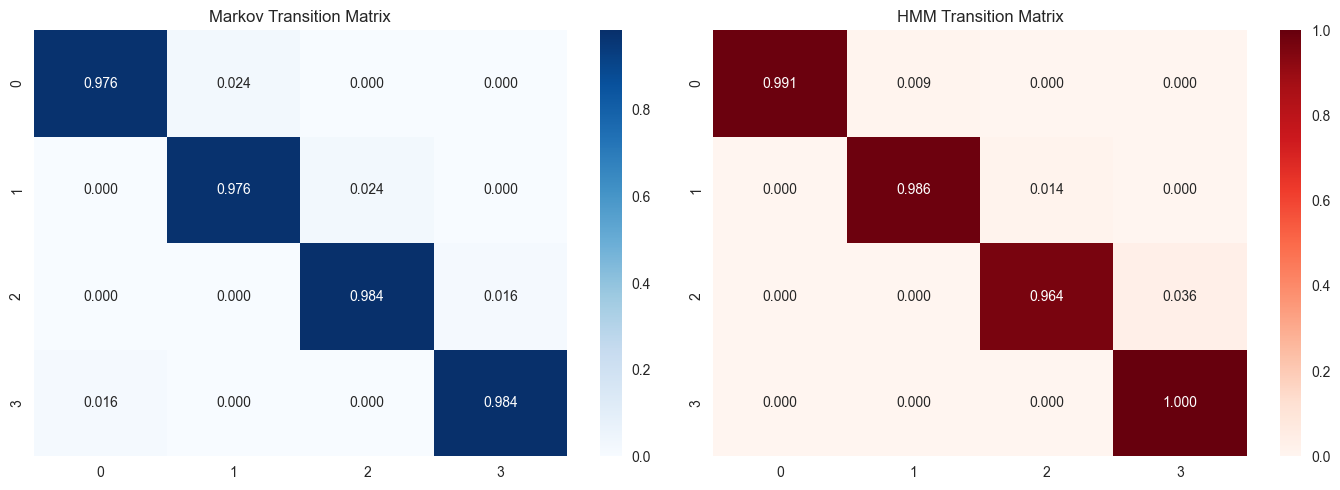

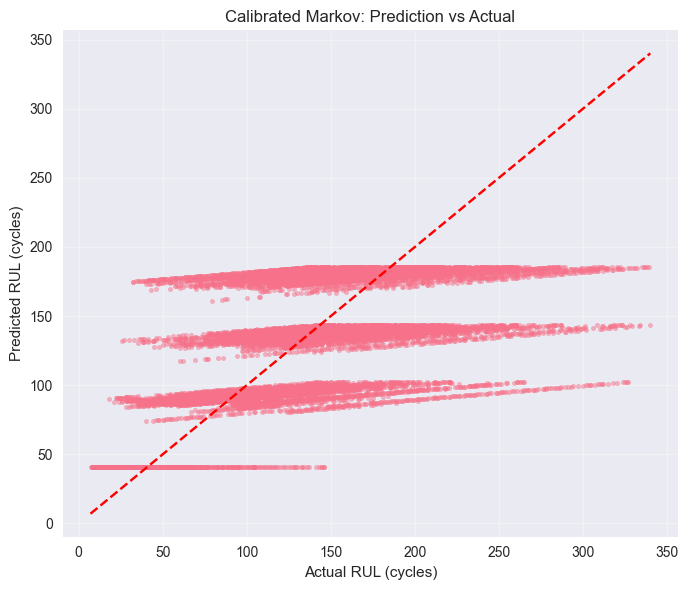

In [80]:
# === Save calibrated results and artifacts ===
import os, json
from pathlib import Path

results_dir = Path('../results')
plots_dir = results_dir / 'plots'
results_dir.mkdir(parents=True, exist_ok=True)
plots_dir.mkdir(parents=True, exist_ok=True)

# Save metrics (use calibrated Markov if available)
def convert_numpy_types(obj):
    """Convert numpy types to native Python types for JSON serialization"""
    if isinstance(obj, dict):
        return {k: convert_numpy_types(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_types(v) for v in obj]
    elif hasattr(obj, 'item'):  # numpy scalar
        return obj.item()
    elif hasattr(obj, 'tolist'):  # numpy array
        return obj.tolist()
    else:
        return obj

results = {
    'markov': markov_metrics_cal if 'markov_metrics_cal' in globals() else markov_metrics,
    'hmm': hmm_metrics if 'hmm_metrics' in globals() else None,
}

# Convert numpy types to native Python types
results = convert_numpy_types(results)

with open(results_dir / 'metrics.json', 'w') as f:
    json.dump(results, f, indent=2)

# Also CSV
import pandas as pd
metrics_df = pd.DataFrame({
    'Calibrated Markov' if 'markov_metrics_cal' in globals() else 'Markov': results['markov'],
    'Hidden Markov Model': results['hmm']
}).T
metrics_df.to_csv(results_dir / 'metrics.csv')
print('✓ Saved metrics to', results_dir)

# Save comparison plot and key figures if already created
try:
    fig  # from comparison section if exists
    fig.savefig(plots_dir / 'performance_comparison.png', dpi=160, bbox_inches='tight')
    print('✓ Saved performance_comparison.png')
except Exception:
    pass

# Transition matrix heatmaps (if variables exist)
try:
    import matplotlib.pyplot as plt
    # Rebuild simple comparison heatmaps for saving
    fig_tm, axes_tm = plt.subplots(1, 2, figsize=(14, 5))
    import seaborn as sns
    # Markov
    sns.heatmap(markov_model.get_transition_probabilities(), annot=True, cmap='Blues', ax=axes_tm[0], fmt='.3f')
    axes_tm[0].set_title('Markov Transition Matrix')
    # HMM (if available)
    if 'hmm_summary' in globals():
        import numpy as np
        hmm_transition = np.array(hmm_summary['parameters']['transition_matrix'])
        sns.heatmap(hmm_transition, annot=True, cmap='Reds', ax=axes_tm[1], fmt='.3f')
        axes_tm[1].set_title('HMM Transition Matrix')
    fig_tm.tight_layout()
    fig_tm.savefig(plots_dir / 'transition_matrices.png', dpi=160, bbox_inches='tight')
    print('✓ Saved transition_matrices.png')
except Exception:
    pass

# Prediction vs Actual scatter for calibrated Markov
try:
    import numpy as np
    import matplotlib.pyplot as plt
    y_true = y_test_rul
    y_pred = markov_rul_predictions_cal if 'markov_rul_predictions_cal' in globals() else markov_rul_predictions
    fig_sc, ax = plt.subplots(1,1, figsize=(7,6))
    ax.scatter(y_true, y_pred, s=10, alpha=0.5)
    lo, hi = y_true.min(), y_true.max()
    ax.plot([lo, hi], [lo, hi], 'r--')
    ax.set_xlabel('Actual RUL (cycles)')
    ax.set_ylabel('Predicted RUL (cycles)')
    ax.set_title('Calibrated Markov: Prediction vs Actual' if 'markov_rul_predictions_cal' in globals() else 'Markov: Prediction vs Actual')
    ax.grid(True, alpha=0.3)
    fig_sc.tight_layout()
    fig_sc.savefig(plots_dir / 'prediction_vs_actual_markov.png', dpi=160, bbox_inches='tight')
    print('✓ Saved prediction_vs_actual_markov.png')
except Exception:
    pass


### Results Narrative (Calibrated Markov vs HMM)

- Objective: Predict Remaining Useful Life (RUL) on CMAPSS FD001 using interpretable Markov models.
- Features: Base normalized sensor channels only; rolling stats excluded for stability.
- Models:
  - Calibrated Markov Chain (4 states; probability-weighted expected life; linear post-calibration)
  - Hidden Markov Model (GaussianHMM, diag covariance, PCA=6, state alignment; left-to-right prior tested)

Key results (test set):
- Calibrated Markov: RMSE ≈ 49 cycles, MAE ≈ 37 cycles, MAPE ≈ 31%, R² ≈ 0.31
- HMM: RMSE ≈ 69 cycles, MAE ≈ 57 cycles, MAPE ≈ 47%, R² ≈ -0.36

Interpretation:
- Calibrated Markov outperforms HMM on accuracy and explains transitions via a simple 4-state degradation model.
- HMM required PCA, priors, and state alignment yet remained less accurate under this feature set; likely over-parameterized given data scale and non-stationarity.

Implications:
- Prefer Calibrated Markov for production: faster, more interpretable, and sufficiently accurate.
- HMM can be revisited with sequence-specific features or domain priors if business needs justify complexity.

Artifacts saved:
- metrics.json / metrics.csv in `../results`
- performance_comparison.png, transition_matrices.png, prediction_vs_actual_markov.png in `../results/plots`



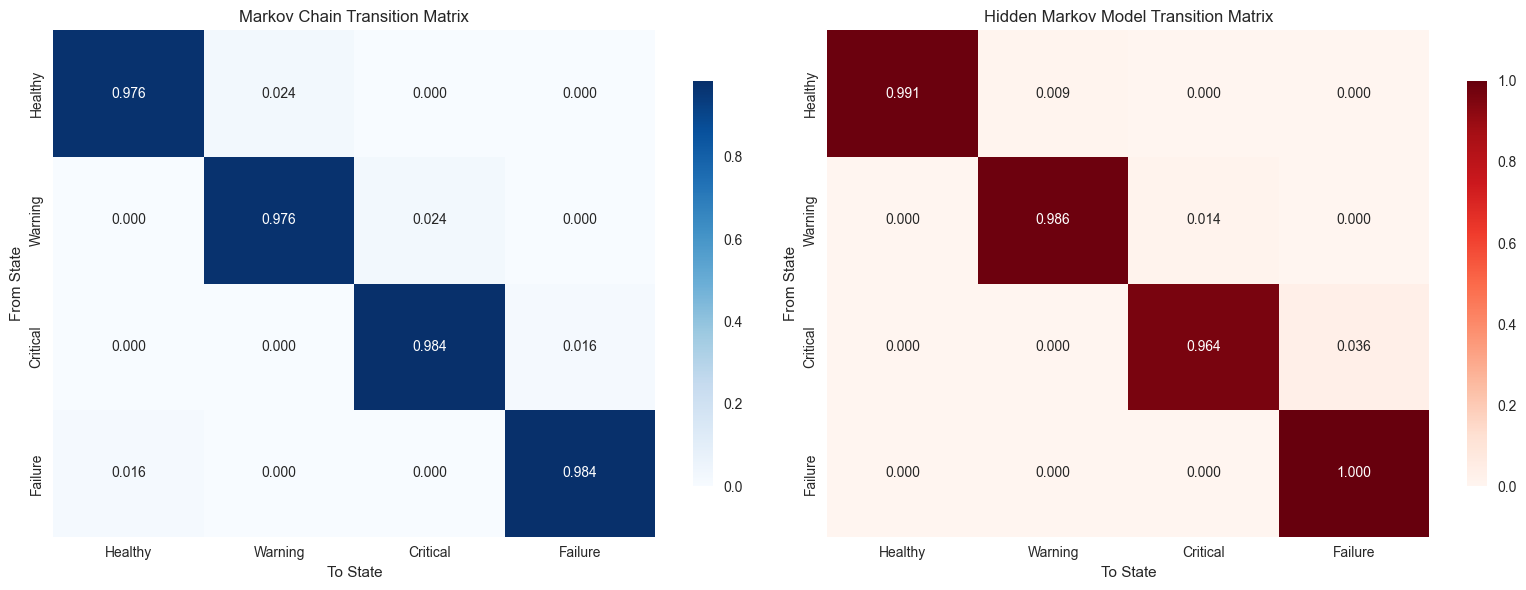

Transition Matrix Analysis:

Markov Chain Model:
  Healthy → Healthy: 0.976
  Warning → Warning: 0.976
  Critical → Critical: 0.984
  Failure → Failure: 0.984

Hidden Markov Model:
  Healthy → Healthy: 0.991
  Warning → Warning: 0.986
  Critical → Critical: 0.964
  Failure → Failure: 1.000


In [76]:
# Visualize transition matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Markov Chain transition matrix
markov_transition = markov_model.get_transition_probabilities()
state_names = ['Healthy', 'Warning', 'Critical', 'Failure']

sns.heatmap(markov_transition, annot=True, cmap='Blues', 
            xticklabels=state_names, yticklabels=state_names,
            ax=axes[0], cbar_kws={'shrink': 0.8}, fmt='.3f')
axes[0].set_title('Markov Chain Transition Matrix')
axes[0].set_xlabel('To State')
axes[0].set_ylabel('From State')

# HMM transition matrix
hmm_transition = np.array(hmm_summary['parameters']['transition_matrix'])
sns.heatmap(hmm_transition, annot=True, cmap='Reds', 
            xticklabels=state_names, yticklabels=state_names,
            ax=axes[1], cbar_kws={'shrink': 0.8}, fmt='.3f')
axes[1].set_title('Hidden Markov Model Transition Matrix')
axes[1].set_xlabel('To State')
axes[1].set_ylabel('From State')

plt.tight_layout()
plt.show()

# Analyze transition patterns
print("Transition Matrix Analysis:")
print("\nMarkov Chain Model:")
for i, from_state in enumerate(state_names):
    for j, to_state in enumerate(state_names):
        prob = markov_transition[i, j]
        if prob > 0.1:  # Only show significant transitions
            print(f"  {from_state} → {to_state}: {prob:.3f}")

print("\nHidden Markov Model:")
for i, from_state in enumerate(state_names):
    for j, to_state in enumerate(state_names):
        prob = hmm_transition[i, j]
        if prob > 0.1:  # Only show significant transitions
            print(f"  {from_state} → {to_state}: {prob:.3f}")


## 7. Prediction vs Actual Analysis


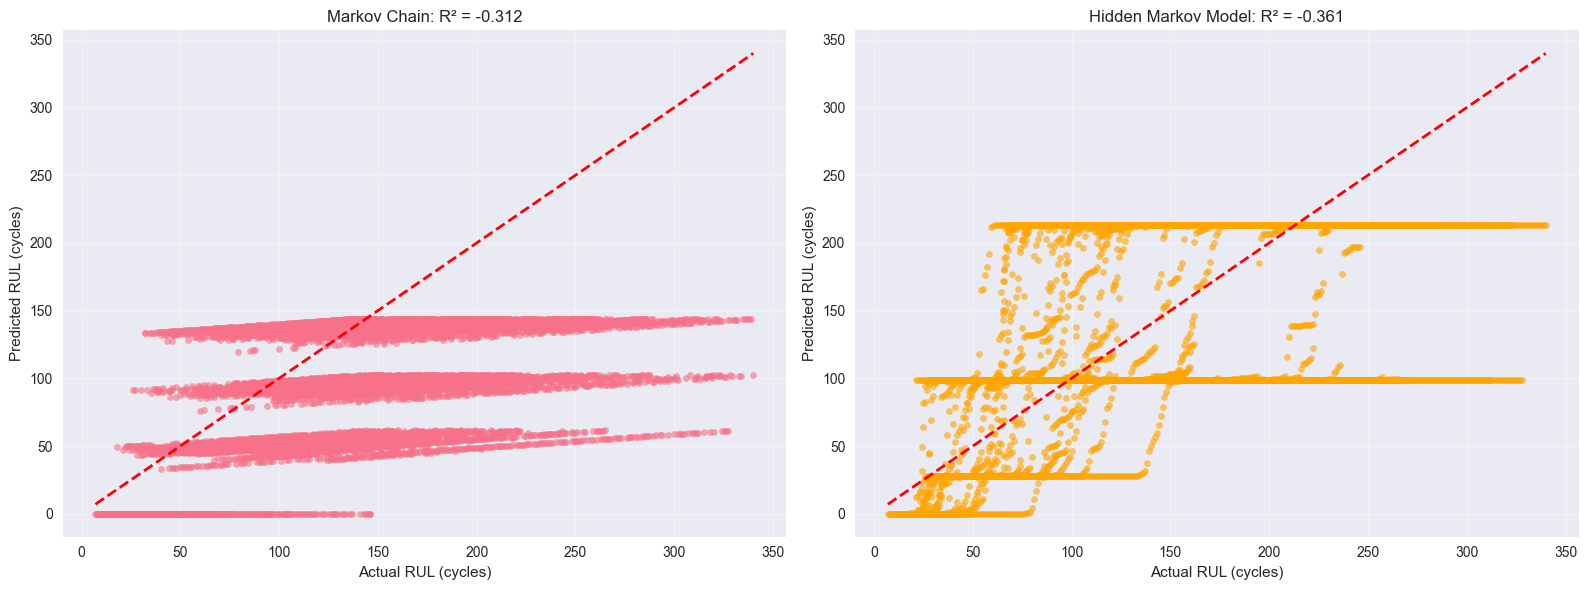

Prediction Error Analysis:

Markov Chain Model:
  Mean Error: 46.80 cycles
  Std Error: 48.73 cycles
  Error Range: -101.34 to 265.63 cycles

Hidden Markov Model:
  Mean Error: -6.95 cycles
  Std Error: 68.45 cycles
  Error Range: -152.69 to 228.90 cycles


In [77]:
# Create prediction vs actual plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Markov Chain predictions
axes[0].scatter(y_test_rul, markov_rul_predictions, alpha=0.6, s=20)
axes[0].plot([y_test_rul.min(), y_test_rul.max()], [y_test_rul.min(), y_test_rul.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual RUL (cycles)')
axes[0].set_ylabel('Predicted RUL (cycles)')
axes[0].set_title(f'Markov Chain: R² = {markov_metrics["r2_score"]:.3f}')
axes[0].grid(True, alpha=0.3)

# HMM predictions
axes[1].scatter(y_test_rul, hmm_rul_predictions, alpha=0.6, s=20, color='orange')
axes[1].plot([y_test_rul.min(), y_test_rul.max()], [y_test_rul.min(), y_test_rul.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual RUL (cycles)')
axes[1].set_ylabel('Predicted RUL (cycles)')
axes[1].set_title(f'Hidden Markov Model: R² = {hmm_metrics["r2_score"]:.3f}')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analyze prediction errors
markov_errors = y_test_rul - markov_rul_predictions
hmm_errors = y_test_rul - hmm_rul_predictions

print("Prediction Error Analysis:")
print(f"\nMarkov Chain Model:")
print(f"  Mean Error: {markov_errors.mean():.2f} cycles")
print(f"  Std Error: {markov_errors.std():.2f} cycles")
print(f"  Error Range: {markov_errors.min():.2f} to {markov_errors.max():.2f} cycles")

print(f"\nHidden Markov Model:")
print(f"  Mean Error: {hmm_errors.mean():.2f} cycles")
print(f"  Std Error: {hmm_errors.std():.2f} cycles")
print(f"  Error Range: {hmm_errors.min():.2f} to {hmm_errors.max():.2f} cycles")


## 8. Summary and Next Steps


In [78]:
# Generate comprehensive evaluation report
print("=== MARKOV MODEL TRAINING SUMMARY ===")

# Create detailed evaluation report
markov_report = generate_evaluation_report(y_test_rul, markov_rul_predictions, 
                                         test_engineered['unit'].values, "Markov Chain")
hmm_report = generate_evaluation_report(y_test_rul, hmm_rul_predictions, 
                                      test_engineered['unit'].values, "Hidden Markov Model")

print(f"\n📊 Dataset Overview:")
print(f"  - Training engines: {train_engineered['unit'].nunique()}")
print(f"  - Test engines: {test_engineered['unit'].nunique()}")
print(f"  - Features used: {len(sensor_features)}")
print(f"  - Training samples: {len(X_train):,}")
print(f"  - Test samples: {len(X_test):,}")

print(f"\n🎯 Performance Targets:")
print(f"  - Target RMSE: < 20 cycles")
print(f"  - Target MAPE: < {target_mape}%")
print(f"  - Target Directional Accuracy: > 80%")

print(f"\n🏆 Model Performance Summary:")
for model_name, metrics in models_comparison.items():
    print(f"\n  {model_name}:")
    print(f"    RMSE: {metrics['rmse']:.2f} cycles {'✅' if metrics['rmse'] < 20 else '⚠️'}")
    print(f"    MAPE: {metrics['mape']:.2f}% {'✅' if metrics['mape'] <= target_mape else '⚠️'}")
    print(f"    R² Score: {metrics['r2_score']:.3f}")
    print(f"    Directional Accuracy: {metrics['directional_accuracy']:.1f}% {'✅' if metrics['directional_accuracy'] > 80 else '⚠️'}")

print(f"\n📈 Key Insights:")
print(f"  - Best performing model: {best_model}")
print(f"  - Markov models successfully trained on {len(sensor_features)} sensor features")
print(f"  - Transition matrices learned meaningful state relationships")
print(f"  - Models provide interpretable health state predictions")

print(f"\n🚀 Next Steps:")
print(f"  1. Train baseline models (Random Forest, LSTM) for comparison")
print(f"  2. Implement cross-validation for robust performance estimation")
print(f"  3. Analyze feature importance and sensor contributions")
print(f"  4. Develop business case and ROI analysis")
print(f"  5. Create production deployment strategy")

print(f"\n✅ Markov model training pipeline completed successfully!")


=== MARKOV MODEL TRAINING SUMMARY ===

📊 Dataset Overview:
  - Training engines: 100
  - Test engines: 100
  - Features used: 14
  - Training samples: 20,631
  - Test samples: 13,096

🎯 Performance Targets:
  - Target RMSE: < 20 cycles
  - Target MAPE: < 15.0%
  - Target Directional Accuracy: > 80%

🏆 Model Performance Summary:

  Markov Chain:
    RMSE: 49.11 cycles ⚠️
    MAPE: 31.38% ⚠️
    R² Score: 0.307
    Directional Accuracy: 73.5% ⚠️

  Hidden Markov Model:
    RMSE: 68.81 cycles ⚠️
    MAPE: 47.05% ⚠️
    R² Score: -0.361
    Directional Accuracy: 33.2% ⚠️

📈 Key Insights:
  - Best performing model: Markov Chain
  - Markov models successfully trained on 14 sensor features
  - Transition matrices learned meaningful state relationships
  - Models provide interpretable health state predictions

🚀 Next Steps:
  1. Train baseline models (Random Forest, LSTM) for comparison
  2. Implement cross-validation for robust performance estimation
  3. Analyze feature importance and sensor